In [1]:
import cartopy.crs as ccrs
import datetime as dt
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4
import numpy as np
import os

In [2]:
# --------------------------------------------------------------------------------------------------
## @package hofx_map
#
#  This application can be triggered by using "application name: hofx_map"
#
#  Configuration options:
#  ----------------------
#
#  The datetime passed to this program is used to parse the file.
#
#  The datetime passed to this file is used to parse the file and so should match any datetime
#  in the file name. If this time is not equivalent to the central time of the window the time
#  offset option described below can be used.
#
#  hofx files       | File(s) to parse. E.g. aircraft_hofx_%Y%m%d%H.nc4
#  variable         | Variable to plot (either something from the file or variable@omb)
#  units            | Units of the field being plotted
#  window length    | Window length (hours)
#  time offset      | Offset of time in filename from window center (hours), e.g. -3, +3 or 0
#  plot format      | Output format for plots ([png] or pdf)
#  colorbar minimum | User defined colorbar minimum
#  colorbar maximum | User defined colorbar maximum
#
#
#  This function can be used to plot fields that are on a lon/lat grid as written by fv3-jedi.
#
# --------------------------------------------------------------------------------------------------

In [3]:
# File containing hofx files
hofx_files_template = '../output/hofx/ssm_hofx_nomodel*.nc'
datetime = '2021-08-16T18:00:00'
window_begin = '2021-08-16T15:00:00'
window_end = '2021-08-16T21:00:00'
metric = 'hofx' #'ObsValue'
field = 'soilMoistureVolumetric'
units = 'm3m-3'
output_path = './'
plotformat = 'png'

colmin = None
colmax = None

# Create output path
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
hofx_files = glob.glob(hofx_files_template)

if hofx_files==[]:
    utils.abort("No hofx files matching the input string")

hofx_files

['../output/hofx/ssm_hofx_nomodel_0002.nc',
 '../output/hofx/ssm_hofx_nomodel_0003.nc',
 '../output/hofx/ssm_hofx_nomodel_0004.nc',
 '../output/hofx/ssm_hofx_nomodel_0000.nc',
 '../output/hofx/ssm_hofx_nomodel_0001.nc',
 '../output/hofx/ssm_hofx_nomodel_0005.nc']

In [5]:
# Loop over data files and read
# -----------------------------
odat = []
lons = []
lats = []
time = []
for hofx_file in hofx_files:
    # Message file being read
    print(" Reading "+hofx_file)

    # Open the file
    fh = netCDF4.Dataset(hofx_file)

    # Read metric
    if metric=='omb':
        odat_proc = fh.groups['ObsValue'].variables[field][:] - fh.groups['hofx'].variables[field][:]
    else:
        odat_proc = fh.groups[metric].variables[field][:]

    # Read metadata
    lons_proc = fh.groups['MetaData'].variables['longitude'][:]
    lats_proc = fh.groups['MetaData'].variables['latitude'][:]
    time_proc = fh.groups['MetaData'].variables['dateTime'][:]


    for m in range(len(odat_proc)):
        odat.append(odat_proc[m])
        lons.append(lons_proc[m])
        lats.append(lats_proc[m])

    fh.close()

 Reading ../output/hofx/ssm_hofx_nomodel_0002.nc
 Reading ../output/hofx/ssm_hofx_nomodel_0003.nc
 Reading ../output/hofx/ssm_hofx_nomodel_0004.nc
 Reading ../output/hofx/ssm_hofx_nomodel_0000.nc
 Reading ../output/hofx/ssm_hofx_nomodel_0001.nc
 Reading ../output/hofx/ssm_hofx_nomodel_0005.nc


In [6]:
# Figure filename
# ---------------
field_savename = field
savename = os.path.join(output_path, field_savename+"_"+metric+"_"+datetime+"."+plotformat)

In [7]:
# Set missing values to nans
missing = 9.0e+30
odat = np.where(np.abs(odat) < missing, odat, float("NaN"))
    
numobs = len(odat)

obarray = np.empty([numobs, 3])

obarray[:, 0] = odat
obarray[:, 1] = lons
obarray[:, 2] = lats


# Compute and print some stats for the data
# -----------------------------------------
stdev = np.nanstd(obarray[:, 0])  # Standard deviation
omean = np.nanmean(obarray[:, 0]) # Mean of the data
datmi = np.nanmin(obarray[:, 0])  # Min of the data
datma = np.nanmax(obarray[:, 0])  # Max of the data

print("Plotted data statistics: ")
print("Mean: ", omean)
print("Standard deviation: ", stdev)
print("Minimum ", datmi)
print("Maximum: ", datma)

<ipython-input-7-4b63f3df711a>:3: UserWarning: Warning: converting a masked element to nan.
  odat = np.where(np.abs(odat) < missing, odat, float("NaN"))
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.


Plotted data statistics: 
Mean:  0.3863639412776183
Standard deviation:  0.16047470451743004
Minimum  0.09298993647098541
Maximum:  1.0


In [8]:
# Norm for scatter plot
# ---------------------
norm = None


# Min max for colorbar
# --------------------
if np.nanmin(obarray[:, 0]) < 0:
    cmax = datma
    cmin = datmi
    cmap = 'RdBu'
else:
    cmax = omean+stdev
    cmin = np.maximum(omean-stdev, 0.0)
    cmap = 'viridis'

if metric == 'PreQC' or metric == 'EffectiveQC':
    cmin = datmi
    cmax = datma

# Specialized colorbar for integers
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[1] = (.5, .5, .5, 1.0)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.insert(np.linspace(0.5, int(cmax)+0.5, int(cmax)+1), 0, 0)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# If using omb then use standard deviation for the cmin/cmax
if metric=='omb' or metric=='ombg' or metric=='oman':
    cmax = stdev
    cmin = -stdev

# Override with user chosen limits
if (colmin!=None):
    print("Using user provided minimum for colorbar")
    cmin = colmin
if (colmax!=None):
    print("Using user provided maximum for colorbar")
    cmax = colmax

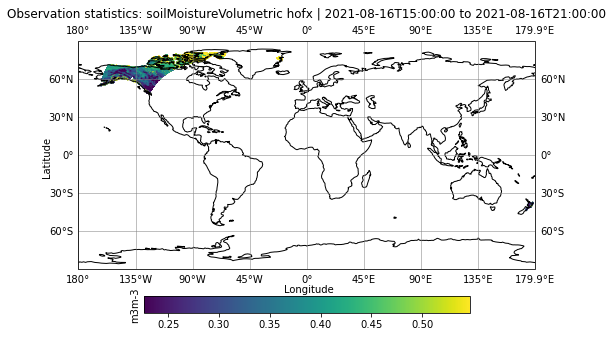

In [11]:
# Create figure
# -------------

fig = plt.figure(figsize=(10, 5))

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=4, linewidth=0,
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=cmin, vmax = cmax, norm=norm)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
ax.set_global()

# draw coastlines
ax.coastlines()

# figure labels
plt.title("Observation statistics: "+field.replace("_"," ")+" "+metric+" | "+
          window_begin+" to "+window_end, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes, rotation='vertical', va='bottom')

plt.show()

In [10]:
!ls ..

Add_elevation_to_old_OWP_obs.ipynb input
Ensemble_plotter.ipynb             logs
GHCND_obs                          make_obs
Increment_plotter.ipynb            output
Modify_restarts.ipynb              run_3dvar.sh
Modify_restarts.py                 run_3dvar_single_obs.sh
OWP_SWE_obs_conus.png              run_converter.sh
OWP_depth_obs_conus.png            run_converter_Mac.sh
OWP_obs                            run_converter_single_obs_Mac.sh
OWP_obs_plotter.ipynb              run_hofx3d.sh
README.md                          run_letkf.sh
SMAP_obs                           run_letkf_oi.sh
Scratch_notebook.ipynb             run_letkf_oi_conus.sh
Single_obs                         run_letkf_oi_taylor_park.sh
UCLDAS                             submit_3dvar.sh
config                             submit_hofx3d.sh
diagnostics                        submit_script.sh
